In [55]:
# %% Cell 1 - Imports & settings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os, math, json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Use inline plotting (Jupyter)
# (If running in other envs, plt.show() will still render)
%matplotlib inline

# Try Prophet first, fallback Holt-Winters
try:
    from prophet import Prophet
    use_prophet = True
except Exception:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    use_prophet = False

from IPython.display import display, Markdown

print("Prophet available?:", use_prophet)


Prophet available?: True


In [56]:
# %% Cell 2 - Load data
DATA_FILE = "data.csv"   # historical dataset (required)
TEST_FILE = "dummydata/test.csv"   # optional actuals for Jan-Mar 2025

def load_data(data_path=DATA_FILE, test_path=TEST_FILE):
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"{data_path} not found in the current working folder.")
    df = pd.read_csv(data_path, parse_dates=["date"])
    assert "product_code" in df.columns and "sales" in df.columns, "Your data must contain 'product_code' and 'sales' columns."
    df = df.sort_values(["product_code","date"]).reset_index(drop=True)
    test_df = None
    if os.path.exists(test_path):
        test_df = pd.read_csv(test_path, parse_dates=["date"])
        test_df = test_df.sort_values(["product_code","date"]).reset_index(drop=True)
    return df, test_df

raw, test_actuals = load_data()
display(Markdown(f"**Loaded**: {len(raw)} rows, **unique products**: {raw['product_code'].nunique()}"))
display(raw.head())


**Loaded**: 564 rows, **unique products**: 10

,date,product_code,sales,category,sub_category,brand,region,mrp,discount,rating
0,2020-01-01,P001,164,Electronics,Mobiles,Samsung,North,15000,0.1,4.5
1,2020-02-01,P001,189,Electronics,Mobiles,Samsung,North,15000,0.1,4.5
2,2020-03-01,P001,232,Electronics,Mobiles,Samsung,North,15000,0.1,4.5
3,2020-04-01,P001,252,Electronics,Mobiles,Samsung,North,15000,0.1,4.5
4,2020-05-01,P001,170,Electronics,Mobiles,Samsung,North,15000,0.1,4.5


In [57]:
# %% Cell 3 - EDA (Exploratory Data Analysis)
raw['date'] = pd.to_datetime(raw['date']).dt.to_period('M').dt.to_timestamp()
global_min = raw['date'].min()
global_max = raw['date'].max()
n_products = raw['product_code'].nunique()

display(Markdown(f"- Data covers **{global_min.date()}** → **{global_max.date()}**"))
display(Markdown(f"- **{n_products}** unique products"))

# Full expected panel size
all_months = pd.date_range(global_min, global_max, freq='MS')
expected_rows = len(all_months) * n_products
missing_rows = max(0, expected_rows - len(raw))

display(Markdown(f"- Expected full panel rows: **{expected_rows}**"))
display(Markdown(f"- Actual rows: **{len(raw)}**"))
display(Markdown(f"- Missing month-rows: **{missing_rows}**"))

# Products with most missing months
prod_month_counts = raw.groupby('product_code')['date'].nunique().reset_index().rename(columns={'date':'n_months_present'})
prod_month_counts['n_months_expected'] = len(all_months)
prod_month_counts['missing_months'] = prod_month_counts['n_months_expected'] - prod_month_counts['n_months_present']
prod_month_counts = prod_month_counts.sort_values('missing_months', ascending=False)
display(Markdown("#### Top 10 products with missing months"))
display(prod_month_counts.head(10))


- Data covers **2020-01-01** → **2024-12-01**

- **10** unique products

- Expected full panel rows: **600**

- Actual rows: **564**

- Missing month-rows: **36**

#### Top 10 products with missing months

,product_code,n_months_present,n_months_expected,missing_months
6,P007,53,60,7
8,P009,54,60,6
7,P008,55,60,5
9,P010,55,60,5
5,P006,56,60,4
2,P003,57,60,3
1,P002,58,60,2
3,P004,58,60,2
4,P005,58,60,2
0,P001,60,60,0


In [58]:
# %% Cell 4 - Preprocessing (Improved Missing Value Handling)
def preprocess_panel(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date']).dt.to_period('M').dt.to_timestamp()
    global_min = df['date'].min()
    global_max = df['date'].max()
    all_months = pd.date_range(global_min, global_max, freq='MS')

    processed = []
    for prod, g in df.groupby('product_code', sort=False):
        g = g.set_index('date').sort_index()
        g = g.reindex(all_months)  # expand to full timeline
        g['product_code'] = prod

        # --- Sales Filling ---
        if 'sales' in g.columns:
            # Step 1: Local smoothing with rolling mean (3 months)
            g['sales'] = g['sales'].fillna(g['sales'].rolling(3, min_periods=1).mean())

            # Step 2: Seasonal averages (same month across years)
            month_avg = g.groupby(g.index.month)['sales'].transform('mean')
            g['sales'] = g['sales'].fillna(month_avg)

            # Step 3: Interpolate + ffill/bfill for any remaining gaps
            g['sales'] = g['sales'].interpolate().ffill().bfill()

        # --- Regressor Filling ---
        for col in g.columns:
            if col not in ('sales','product_code'):
                if col == 'rating':
                    g[col] = g[col].interpolate().ffill().bfill()
                else:
                    g[col] = g[col].ffill().bfill()

        g = g.reset_index().rename(columns={'index':'date'})
        processed.append(g)

    merged = pd.concat(processed, ignore_index=True)
    cols = ['date','product_code'] + [c for c in merged.columns if c not in ('date','product_code')]
    merged = merged[cols].sort_values(['date','product_code']).reset_index(drop=True)
    return merged

processed = preprocess_panel(raw)
display(Markdown(f"Processed shape: **{processed.shape}**"))
display(processed.head(12))


Processed shape: **(600, 10)**

,date,product_code,sales,category,sub_category,brand,region,mrp,discount,rating
0,2020-01-01,P001,164.0,Electronics,Mobiles,Samsung,North,15000.0,0.10,4.5
1,2020-01-01,P002,135.0,Clothing,Shirts,Peter England,West,2500.0,0.20,4.2
2,2020-01-01,P003,173.0,Home & Kitchen,Cookware,Prestige,South,3000.0,0.15,4.8
3,2020-01-01,P004,120.0,Books,Fiction,Penguin,East,500.0,0.05,4.6
4,2020-01-01,P005,80.0,Beauty,Skincare,Lakme,Central,800.0,0.12,4.7
5,2020-01-01,P006,200.0,Appliances,Washing Machines,LG,North,25000.0,0.15,4.7
6,2020-01-01,P007,300.0,Furniture,Sofa,Urban Ladder,West,35000.0,0.20,4.4
7,2020-01-01,P008,50.0,Sports,Cricket Bat,SG,South,2000.0,0.10,4.9
8,2020-01-01,P009,250.0,Groceries,Snacks,Lays,East,20.0,0.00,4.3
9,2020-01-01,P010,150.0,Toys,Action Figures,Hasbro,Central,1000.0,0.10,4.5


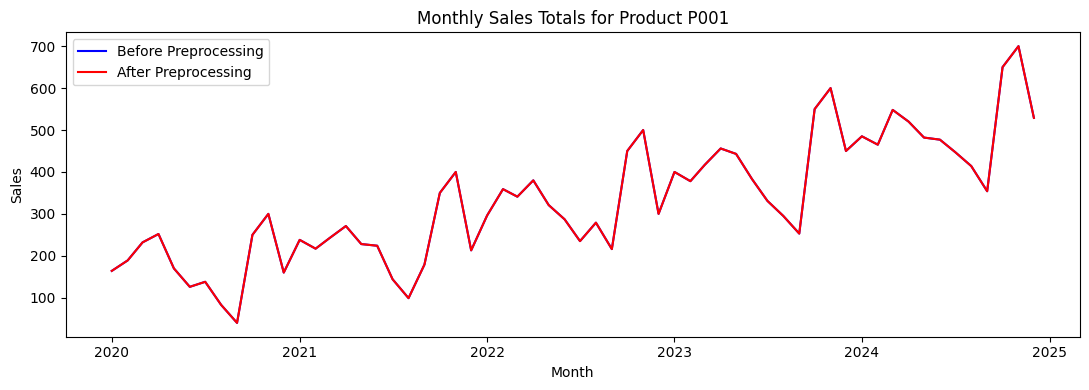

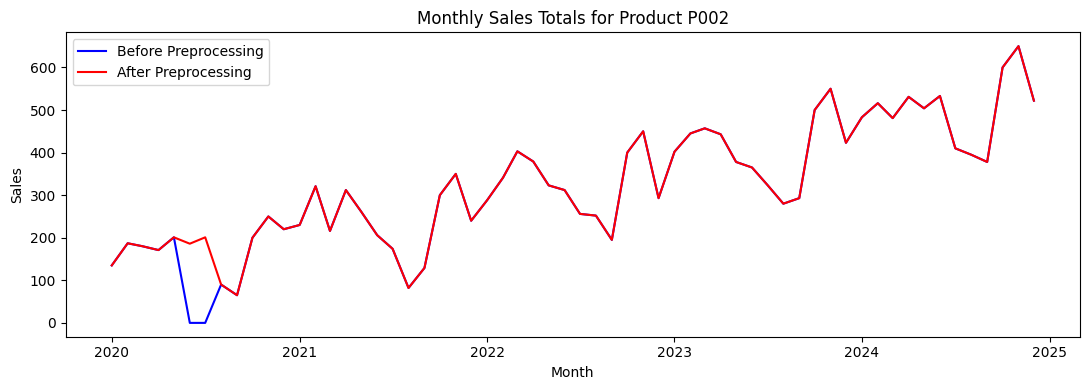

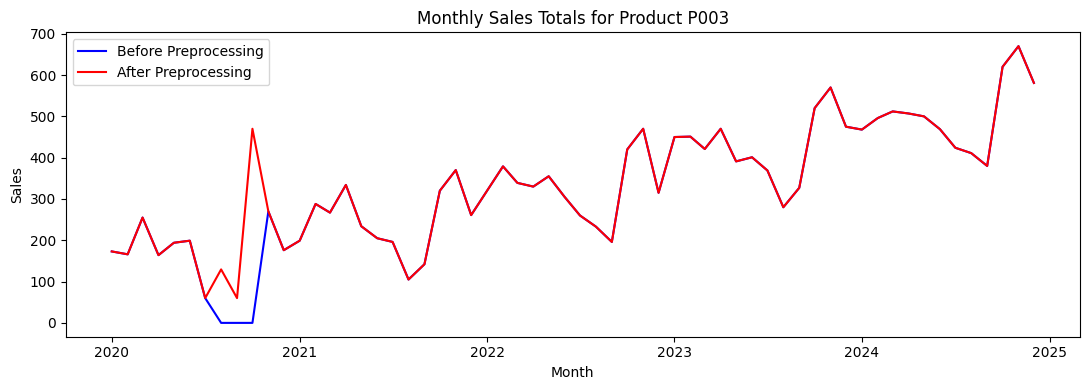

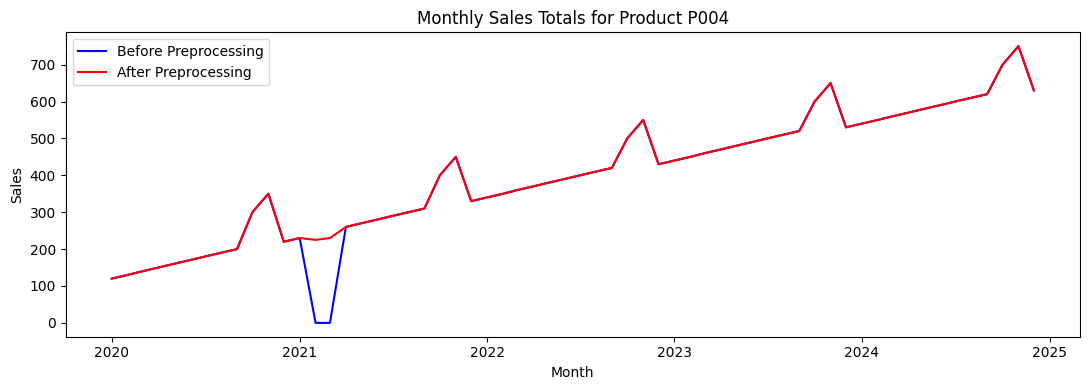

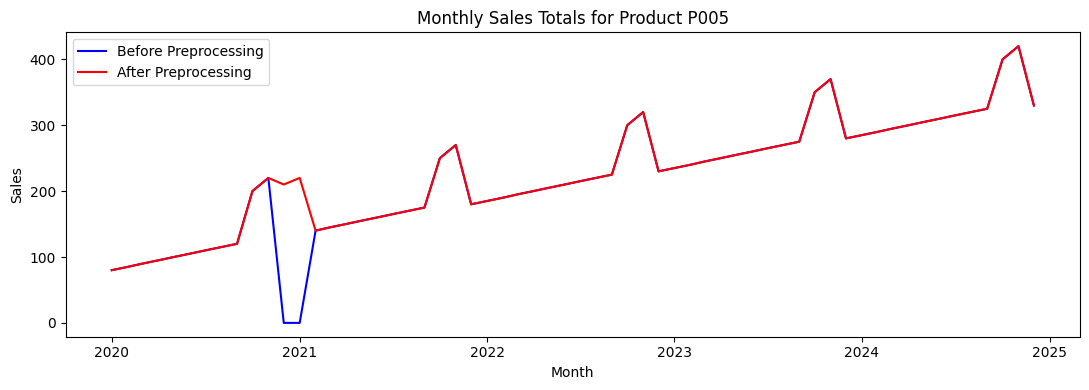

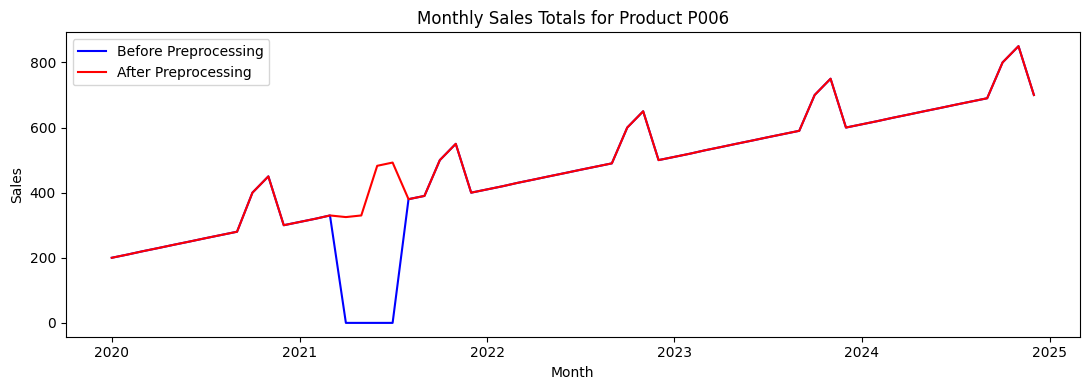

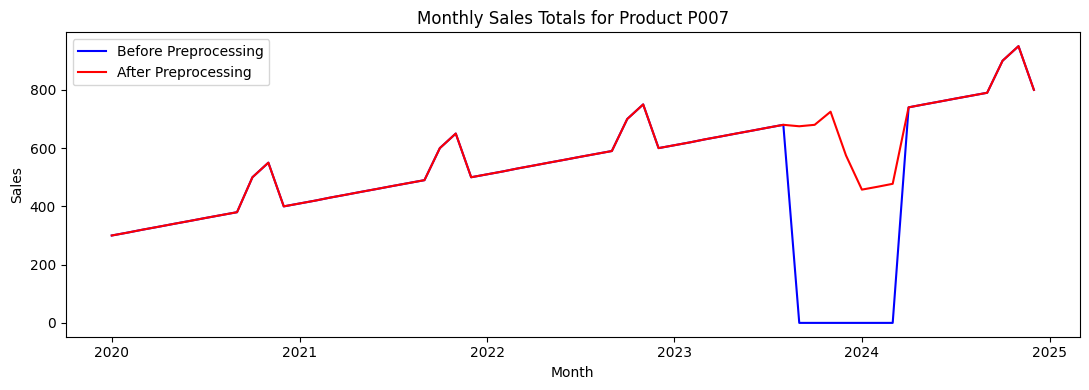

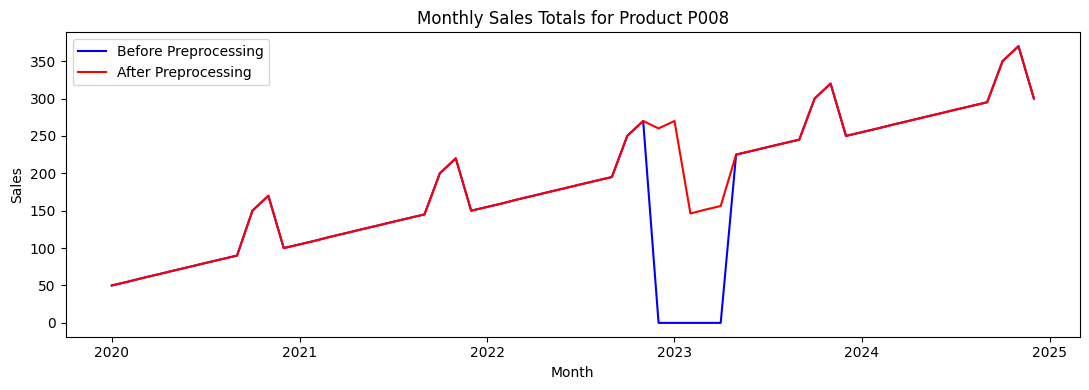

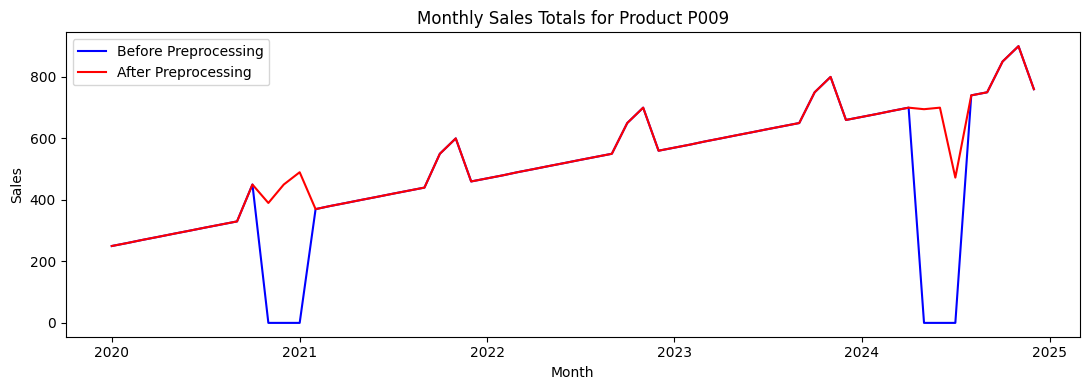

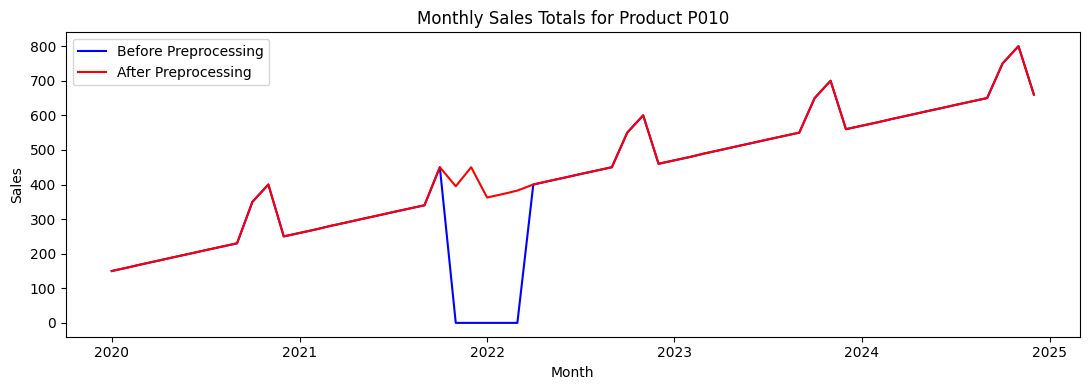

In [59]:
# %% Cell 5 - Product-wise monthly totals before/after (inline)
def plot_monthly_totals_per_product(before_df, after_df):
    products = sorted(before_df['product_code'].unique())
    
    for prod in products:
        before = before_df[before_df['product_code'] == prod]
        after = after_df[after_df['product_code'] == prod]

        before_series = before.groupby('date')['sales'].sum().reindex(
            pd.date_range(before['date'].min(), before['date'].max(), freq='MS')
        ).fillna(0)

        after_series = after.groupby('date')['sales'].sum().reindex(
            pd.date_range(after['date'].min(), after['date'].max(), freq='MS')
        ).fillna(0)

        plt.figure(figsize=(11,4))
        plt.plot(before_series.index, before_series.values, label="Before Preprocessing", color="blue")
        plt.plot(after_series.index, after_series.values, label="After Preprocessing", color="red")
        plt.title(f"Monthly Sales Totals for Product {prod}")
        plt.xlabel("Month")
        plt.ylabel("Sales")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Call function
plot_monthly_totals_per_product(raw, processed)


Example product for visualization: **P007**

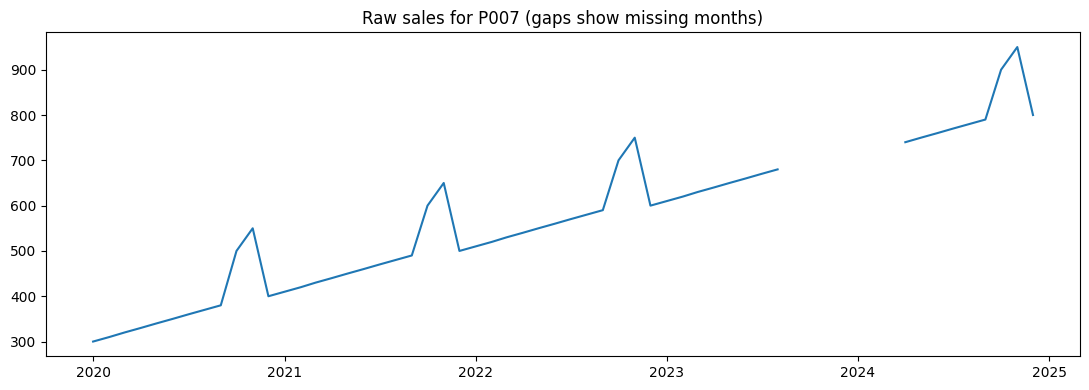

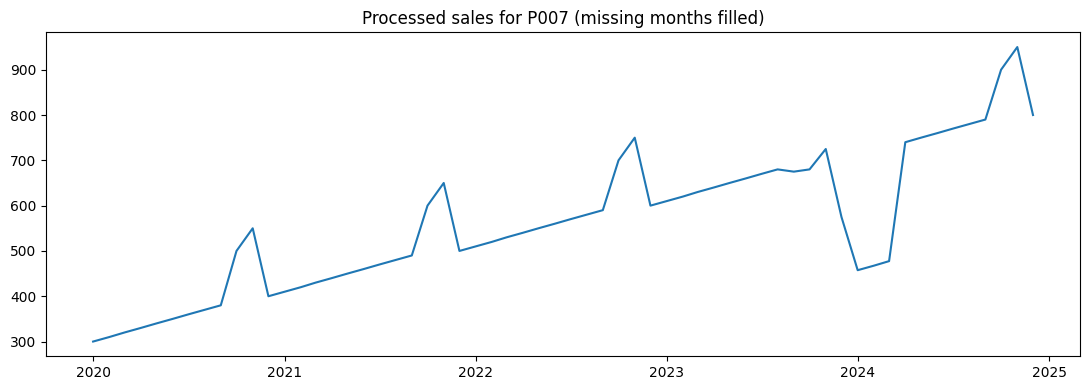

In [60]:
# %% Cell 6 - Example product series before vs after
example = prod_month_counts.loc[prod_month_counts['missing_months']>0,'product_code'].iloc[0] if (prod_month_counts['missing_months']>0).any() else raw['product_code'].unique()[0]
display(Markdown(f"Example product for visualization: **{example}**"))

raw_ex = raw[raw['product_code']==example].set_index('date').sort_index().reindex(pd.date_range(global_min, global_max, freq='MS'))
proc_ex = processed[processed['product_code']==example].set_index('date').sort_index()

plt.figure(figsize=(11,4))
plt.plot(raw_ex.index, raw_ex['sales'].values)
plt.title(f"Raw sales for {example} (gaps show missing months)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,4))
plt.plot(proc_ex.index, proc_ex['sales'].values)
plt.title(f"Processed sales for {example} (missing months filled)")
plt.tight_layout()
plt.show()


In [62]:
# %% Cell 7 - Forecast (Jan-2025 to Mar-2025)
FORECAST_START = pd.to_datetime("2025-01-01")
HORIZON = 3
forecast_months = pd.date_range(FORECAST_START, periods=HORIZON, freq='MS')
display(Markdown(f"Forecast months: **{[d.date() for d in forecast_months]}**"))

def forecast_panel(processed_df, forecast_months, regressors=['mrp','discount','rating']):
    forecasts = []
    for prod, g in processed_df.groupby('product_code'):
        g = g.sort_values('date').reset_index(drop=True)
        if g['sales'].dropna().shape[0] == 0:
            continue
        train = g.copy()
        try:
            if use_prophet:
                m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
                available_regs = [r for r in regressors if r in train.columns]
                for r in available_regs:
                    m.add_regressor(r)
                train_prop = train.rename(columns={'date':'ds','sales':'y'})[['ds','y'] + available_regs]
                m.fit(train_prop)

                # future frame
                future_index = pd.date_range(train['date'].min(), periods=len(train)+len(forecast_months), freq='MS')
                future = pd.DataFrame({'ds': future_index})
                for r in available_regs:
                    tmp = train[['date', r]].rename(columns={'date':'ds'})
                    future = future.merge(tmp, on='ds', how='left')
                    future[r] = future[r].fillna(method='ffill').fillna(method='bfill')
                preds = m.predict(future[['ds'] + available_regs]).set_index('ds')['yhat']
                for fm in forecast_months:
                    val = preds.get(fm, np.nan)
                    forecasts.append({'date': fm, 'product_code': prod, 'forecast': float(np.nan if pd.isna(val) else val)})
            else:
                # ETS fallback
                if train['sales'].dropna().shape[0] < 12:
                    last_val = float(train['sales'].dropna().iloc[-1]) if train['sales'].dropna().shape[0]>0 else 0.0
                    for fm in forecast_months:
                        forecasts.append({'date': fm, 'product_code': prod, 'forecast': last_val})
                else:
                    model = ExponentialSmoothing(train['sales'], seasonal='add', seasonal_periods=12)
                    fit = model.fit()
                    fc = fit.forecast(len(forecast_months))
                    for i, fm in enumerate(forecast_months):
                        forecasts.append({'date': fm, 'product_code': prod, 'forecast': float(fc[i])})
        except Exception:
            last_val = float(train['sales'].dropna().iloc[-1]) if train['sales'].dropna().shape[0]>0 else 0.0
            for fm in forecast_months:
                forecasts.append({'date': fm, 'product_code': prod, 'forecast': last_val})
    fdf = pd.DataFrame(forecasts).sort_values(['date','product_code']).reset_index(drop=True)
    return fdf

forecasts = forecast_panel(processed, forecast_months)
display(Markdown(f"Produced **{len(forecasts)}** forecast rows for {forecasts['product_code'].nunique()} products"))
display(forecasts.head(20))


Forecast months: **[datetime.date(2025, 1, 1), datetime.date(2025, 2, 1), datetime.date(2025, 3, 1)]**

01:28:24 - cmdstanpy - INFO - Chain [1] start processing
01:28:24 - cmdstanpy - INFO - Chain [1] done processing
01:28:24 - cmdstanpy - INFO - Chain [1] start processing
01:28:25 - cmdstanpy - INFO - Chain [1] done processing
01:28:25 - cmdstanpy - INFO - Chain [1] start processing
01:28:25 - cmdstanpy - INFO - Chain [1] done processing
01:28:25 - cmdstanpy - INFO - Chain [1] start processing
01:28:26 - cmdstanpy - INFO - Chain [1] done processing
01:28:26 - cmdstanpy - INFO - Chain [1] start processing
01:28:26 - cmdstanpy - INFO - Chain [1] done processing
01:28:26 - cmdstanpy - INFO - Chain [1] start processing
01:28:26 - cmdstanpy - INFO - Chain [1] done processing
01:28:27 - cmdstanpy - INFO - Chain [1] start processing
01:28:27 - cmdstanpy - INFO - Chain [1] done processing
01:28:27 - cmdstanpy - INFO - Chain [1] start processing
01:28:27 - cmdstanpy - INFO - Chain [1] done processing
01:28:27 - cmdstanpy - INFO - Chain [1] start processing
01:28:28 - cmdstanpy - INFO - Chain [1]

Produced **30** forecast rows for 10 products

,date,product_code,forecast
0,2025-01-01,P001,578.534270
1,2025-01-01,P002,576.215956
2,2025-01-01,P003,537.398521
3,2025-01-01,P004,640.310862
4,2025-01-01,P005,372.453430
5,2025-01-01,P006,700.190808
6,2025-01-01,P007,775.747188
7,2025-01-01,P008,309.508467
8,2025-01-01,P009,817.396354
9,2025-01-01,P010,671.181654


### Per-product metrics

,product_code,n_points,mape,smape,rmse,accuracy
0,P001,3,12.252787,11.522072,65.852655,87.747213
1,P002,3,13.622662,12.428775,85.671184,86.377338
2,P003,3,6.276754,6.279384,43.095223,93.723246
3,P004,3,1.374023,1.356838,12.239143,98.625977
4,P005,3,5.272221,5.186299,22.376978,94.727779
5,P006,3,1.759212,1.752262,13.234066,98.240788
6,P007,3,4.891996,5.107630,53.037330,95.108004
7,P008,3,3.062739,3.189744,16.267897,96.937261
8,P009,3,3.287576,3.238998,30.033783,96.712424
9,P010,3,1.740465,1.702055,18.234780,98.259535


### Aggregated metrics (unweighted across products)

,value
mape_mean,5.354043
smape_mean,5.176406
rmse_mean,36.004304
accuracy_mean,94.645957


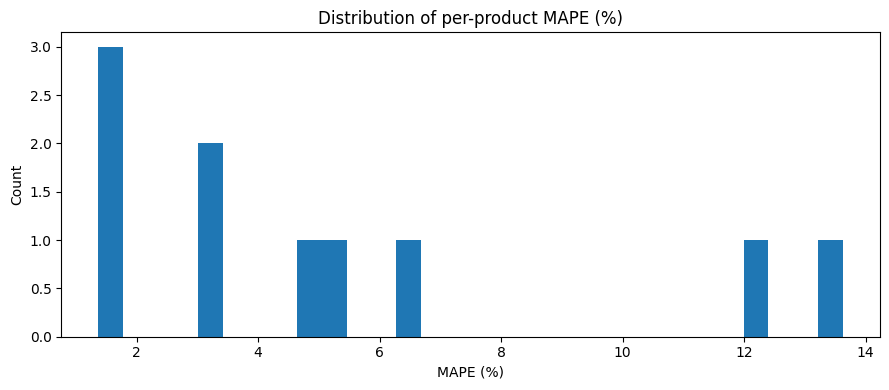

### Top 10 worst MAPE products

,product_code,n_points,mape,smape,rmse,accuracy
1,P002,3,13.622662,12.428775,85.671184,86.377338
0,P001,3,12.252787,11.522072,65.852655,87.747213
2,P003,3,6.276754,6.279384,43.095223,93.723246
4,P005,3,5.272221,5.186299,22.376978,94.727779
6,P007,3,4.891996,5.107630,53.037330,95.108004
8,P009,3,3.287576,3.238998,30.033783,96.712424
7,P008,3,3.062739,3.189744,16.267897,96.937261
5,P006,3,1.759212,1.752262,13.234066,98.240788
9,P010,3,1.740465,1.702055,18.234780,98.259535
3,P004,3,1.374023,1.356838,12.239143,98.625977


### Top 10 best MAPE products

,product_code,n_points,mape,smape,rmse,accuracy
3,P004,3,1.374023,1.356838,12.239143,98.625977
9,P010,3,1.740465,1.702055,18.234780,98.259535
5,P006,3,1.759212,1.752262,13.234066,98.240788
7,P008,3,3.062739,3.189744,16.267897,96.937261
8,P009,3,3.287576,3.238998,30.033783,96.712424
6,P007,3,4.891996,5.107630,53.037330,95.108004
4,P005,3,5.272221,5.186299,22.376978,94.727779
2,P003,3,6.276754,6.279384,43.095223,93.723246
0,P001,3,12.252787,11.522072,65.852655,87.747213
1,P002,3,13.622662,12.428775,85.671184,86.377338


In [63]:
# %% Cell 8 - Metrics & error visualizations (only if test_actuals provided)
def smape(a,f):
    a = np.array(a, dtype=float); f = np.array(f, dtype=float)
    denom = (np.abs(a) + np.abs(f))
    with np.errstate(divide='ignore', invalid='ignore'):
        res = np.where(denom==0, 0.0, 2.0 * np.abs(f-a) / denom)
    return np.nanmean(res) * 100.0

def compute_metrics_series(a,f):
    a = np.array(a, dtype=float); f = np.array(f, dtype=float)
    mask = ~np.isnan(a)
    if mask.sum() == 0:
        return {'mape': None, 'smape': None, 'rmse': None, 'accuracy': None}
    a = a[mask]; f = f[mask]
    nonzero = a != 0
    mape_val = None
    if nonzero.sum() > 0:
        mape_val = float(np.mean(np.abs((a[nonzero] - f[nonzero]) / a[nonzero])) * 100.0)
    smape_val = float(smape(a,f))
    rmse_val = float(math.sqrt(mean_squared_error(a,f)))
    acc_val = None if mape_val is None else float(100.0 - mape_val)
    return {'mape': mape_val, 'smape': smape_val, 'rmse': rmse_val, 'accuracy': acc_val}

if test_actuals is None:
    display(Markdown("**No `test.csv` found** — skipping metric computation. To compute metrics, add `test.csv` with columns: date, product_code, sales"))
else:
    test_actuals['date'] = pd.to_datetime(test_actuals['date']).dt.to_period('M').dt.to_timestamp()
    test_window = test_actuals[test_actuals['date'].isin(forecast_months)]
    merged = forecasts.merge(test_window[['date','product_code','sales']], on=['date','product_code'], how='left')

    metrics_rows = []
    for prod, g in merged.groupby('product_code'):
        a = g['sales'].values
        f = g['forecast'].values
        mets = compute_metrics_series(a,f)
        metrics_rows.append({'product_code': prod, 'n_points': int(g.shape[0]), **mets})
    metrics_df = pd.DataFrame(metrics_rows)
    display(Markdown("### Per-product metrics"))
    display(metrics_df.head(50))

    # aggregated metrics summary
    valid_mape = metrics_df['mape'].dropna()
    valid_smape = metrics_df['smape'].dropna()
    valid_rmse = metrics_df['rmse'].dropna()
    valid_acc = metrics_df['accuracy'].dropna()
    agg = {
        'mape_mean': float(valid_mape.mean()) if not valid_mape.empty else None,
        'smape_mean': float(valid_smape.mean()) if not valid_smape.empty else None,
        'rmse_mean': float(valid_rmse.mean()) if not valid_rmse.empty else None,
        'accuracy_mean': float(valid_acc.mean()) if not valid_acc.empty else None,
    }
    display(Markdown("### Aggregated metrics (unweighted across products)"))
    display(pd.DataFrame([agg]).T.rename(columns={0:'value'}))

    # histogram of per-product MAPE (inline)
    if not valid_mape.empty:
        plt.figure(figsize=(9,4))
        plt.hist(valid_mape.values, bins=30)
        plt.title("Distribution of per-product MAPE (%)")
        plt.xlabel("MAPE (%)")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # show top/bottom error products
    display(Markdown("### Top 10 worst MAPE products"))
    display(metrics_df.sort_values('mape', ascending=False).head(10))
    display(Markdown("### Top 10 best MAPE products"))
    display(metrics_df.sort_values('mape', ascending=True).head(10))


### Top 10 products by total forecast (3-month window)

,product_code,forecast
8,P009,2328.620763
6,P007,2311.933973
5,P006,2130.713462
9,P010,2044.051843
3,P004,1935.979782
1,P002,1836.971227
0,P001,1784.385823
2,P003,1766.245950
4,P005,1032.570953
7,P008,899.912205


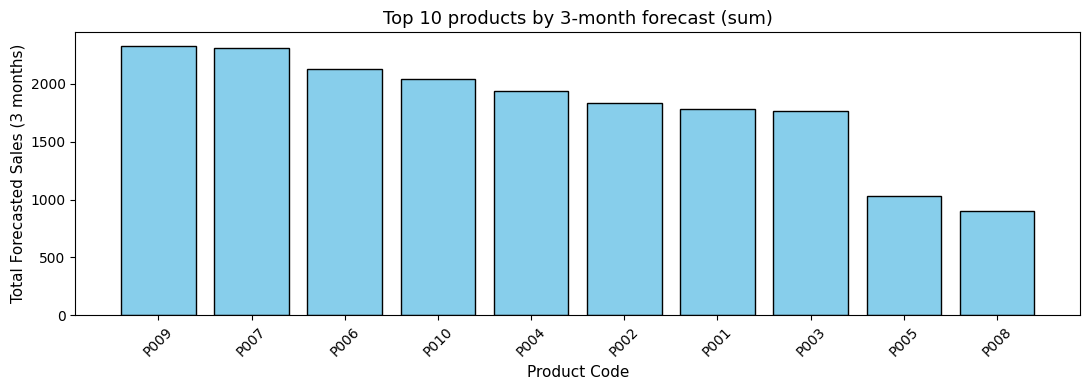

### Actual vs Forecast for top 3 products

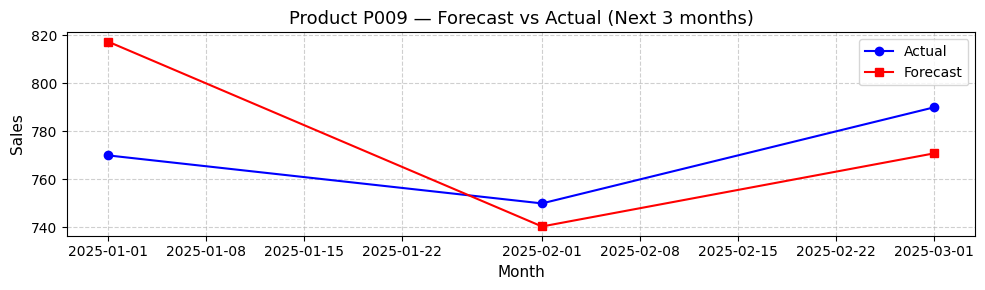

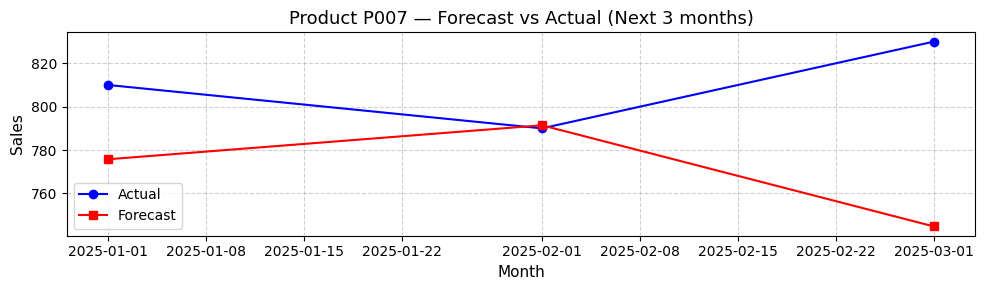

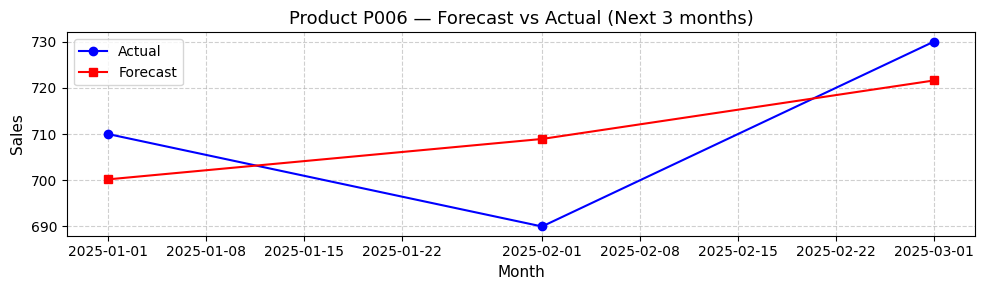

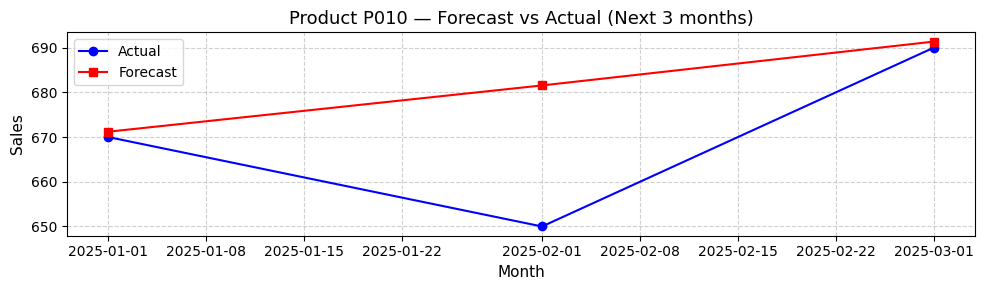

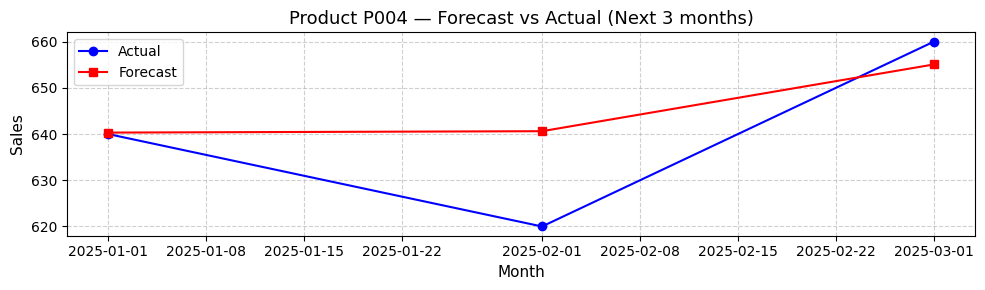

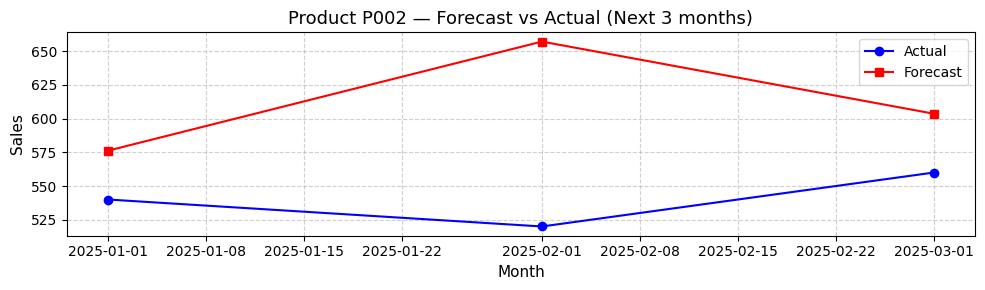

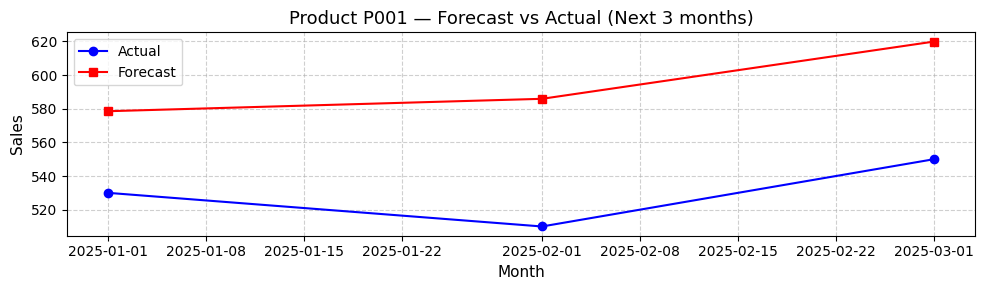

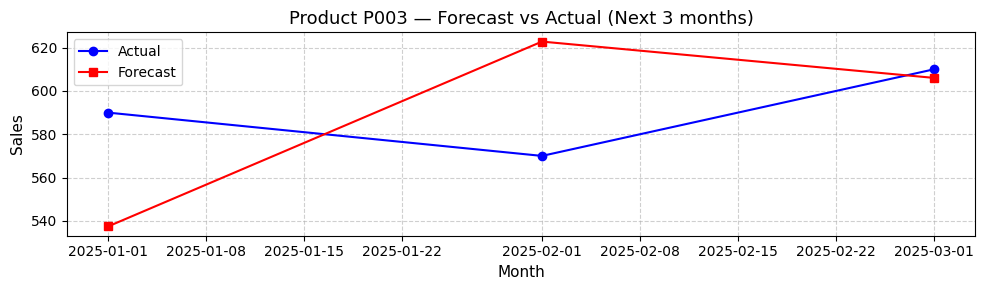

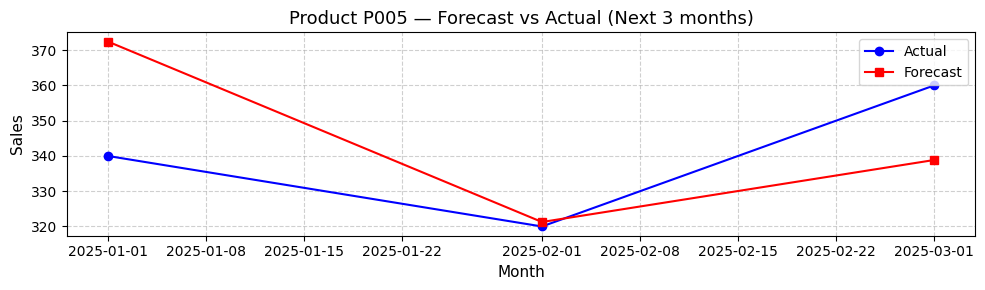

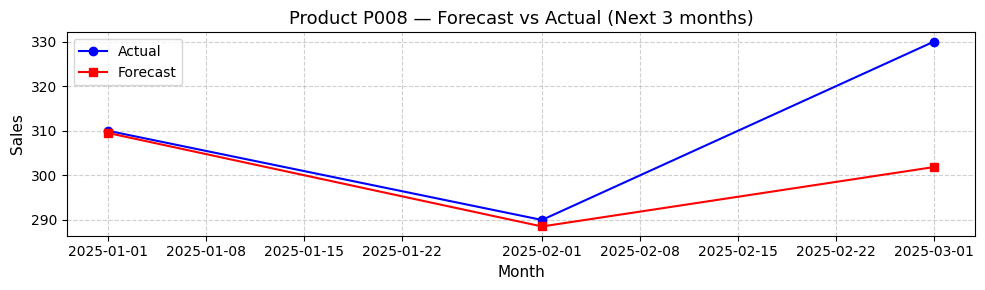

In [64]:
# %% Cell 9 - Analytics & Actual vs Forecast plots (inline)

# Top N products by 3-month forecast total
top_n = 10
top_forecast = forecasts.groupby('product_code')['forecast'].sum().reset_index().sort_values('forecast', ascending=False)
display(Markdown(f"### Top {top_n} products by total forecast (3-month window)"))
display(top_forecast.head(top_n))

# --- Bar chart for top N ---
top_plot = top_forecast.head(top_n).set_index('product_code')
plt.figure(figsize=(11,4))
plt.bar(top_plot.index, top_plot['forecast'], color="skyblue", edgecolor="black")
plt.title(f"Top {top_n} products by 3-month forecast (sum)", fontsize=13)
plt.xlabel("Product Code", fontsize=11)
plt.ylabel("Total Forecasted Sales (3 months)", fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Actual vs Forecast for top 3 products ---
top3 = top_forecast['product_code'].iloc[:].tolist()
display(Markdown("### Actual vs Forecast for top 3 products"))

for prod in top3:
    p_fc = forecasts[forecasts['product_code']==prod].set_index('date').sort_index()
    plt.figure(figsize=(10,3))

    if test_actuals is not None:
        p_actual = test_actuals[(test_actuals['product_code']==prod) & (test_actuals['date'].isin(forecast_months))].set_index('date').sort_index()
        if not p_actual.empty:
            plt.plot(p_actual.index, p_actual['sales'].values, label="Actual", marker="o", color="blue")

    plt.plot(p_fc.index, p_fc['forecast'].values, label="Forecast", marker="s", color="red")
    plt.title(f"Product {prod} — Forecast vs Actual (Next 3 months)", fontsize=13)
    plt.xlabel("Month", fontsize=11)
    plt.ylabel("Sales", fontsize=11)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
